In [707]:
import numpy as np
import matplotlib.pyplot as plt

from src.environments import BatteryChargingEnv
from src.utils import Discretizer
from src.agents.dqn import DFHqn, Dqn
from src.agents.fhtlr import FHTlr

* DQN and FHDQN without ER buffer work worse (buffer_size=1)

# 1) Inventory

In [512]:
GAMMA = 0.99
H = 5

ENV = BatteryChargingEnv(H=H)

DISCRETIZER = Discretizer(
    min_points_states=[0, 0, 0, 0],
    max_points_states=[1, 1, 1, 1],
    bucket_states=[10, 10, 10, 10],
    min_points_actions=[0, 0, 0],
    max_points_actions=[1, 1, 1],
    bucket_actions=[10, 10, 10],
)

# 2) Training

In [652]:
EPISODES = 20_000

In [653]:
def run_train_episode(env, agent, eps, eps_decay, H):
    s, _ = env.reset()
    for h in range(H):
        a = agent.select_action(s, h, eps)
        sp, r, d, _, _ = env.step(a)
        agent.buffer.append(h, s, a, sp, r, d)
        agent.update()

        if d:
            break

        s = sp
        eps *= eps_decay
    return eps

In [654]:
def run_test_episode(env, agent, H):
    G = 0
    s, _ = env.reset()
    for h in range(H):
        a = agent.select_greedy_action(s, h)
        s, r, d, _, _ = env.step(a)
        G += r

        if d:
            break
    return G

# 3) DQN

In [700]:
ALPHA_DQN = 0.1
BUFFER_SIZE = 1_000

In [701]:
eps_decay = 0.99999
Gs_dqn = []

for i in range(10):
    Gs = []
    eps = 1.0
    dqn_learner = Dqn(DISCRETIZER, ALPHA_DQN, GAMMA, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, dqn_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, dqn_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_dqn.append(Gs)
Gs_dqn = np.array(Gs_dqn)

Trial: 9 - Episode: 9990 - Return: -14.79 - Eps: 0.678

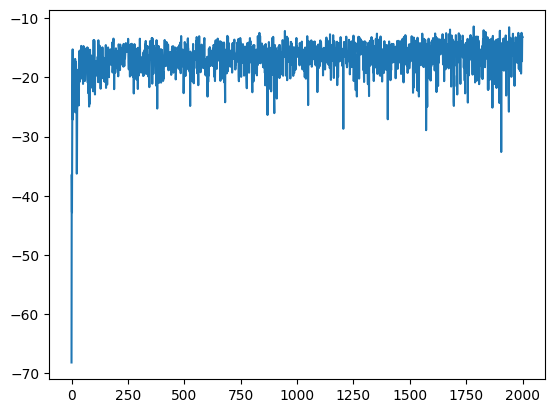

In [663]:
plt.plot(Gs_dqn.mean(axis=0))
# plt.plot(Gs_dqn[2])
plt.show()

# 4) FH-DQN

In [703]:
ALPHA_DQN = 0.1
BUFFER_SIZE = 1_000

In [704]:
eps_decay = 0.9999
Gs_fhdqn = []

for i in range(10):
    Gs = []
    eps = 1.0
    dfhqn_learner = DFHqn(DISCRETIZER, ALPHA_DQN, H, BUFFER_SIZE)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, dfhqn_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, dfhqn_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_fhdqn.append(Gs)
Gs_fhdqn = np.array(Gs_fhdqn)

Trial: 9 - Episode: 9990 - Return: -13.32 - Eps: 0.028

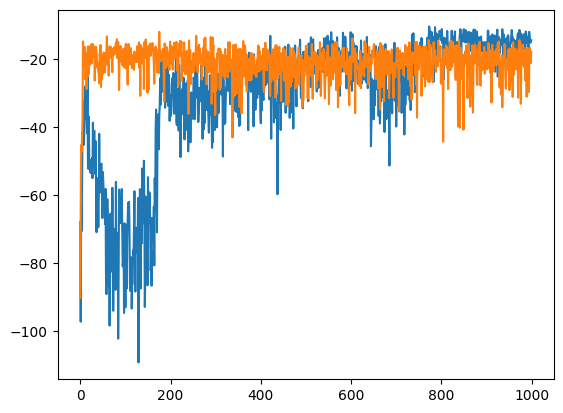

In [705]:
Gs_fhdqn = np.array(Gs_fhdqn)

plt.plot(Gs_fhdqn.mean(axis=0))
plt.plot(Gs_dqn.mean(axis=0))
# plt.plot(Gs_fhdqn[2])
plt.show()

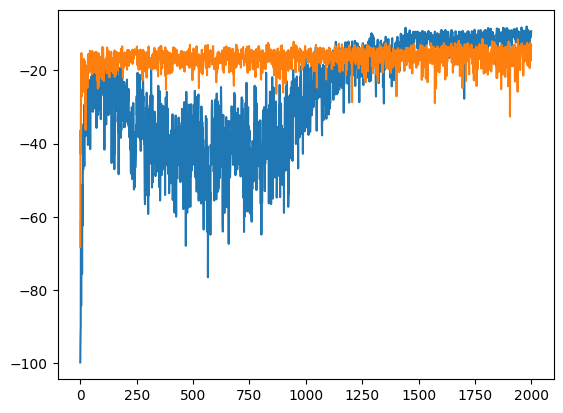

In [ ]:
Gs_fhdqn = np.array(Gs_fhdqn)

plt.plot(Gs_fhdqn.mean(axis=0))
plt.plot(Gs_dqn.mean(axis=0))
# plt.plot(Gs_fhdqn[2])
plt.show()

# 5) TLR

In [665]:
ALPHA_FHTLR = 0.1
K = 50 # 100
SCALE = 0.5
W_DECAY = 0.0

In [667]:
eps_decay = 0.9999 # 0.99995 # 0.99999
Gs_fhtlr = []

for i in range(10):
    Gs = []
    eps = 1.0
    fhtlr_learner = FHTlr(DISCRETIZER, ALPHA_FHTLR, H, K, SCALE, w_decay=W_DECAY)
    for e in range(EPISODES):
        eps = run_train_episode(ENV, fhtlr_learner, eps, eps_decay, H)
        if e % 10 == 0:
            G = run_test_episode(ENV, fhtlr_learner, H)
            Gs.append(G)
            print(f"\rTrial: {i} - Episode: {e} - Return: {np.around(G, 2)} - Eps: {np.around(eps, 2)}", end="")
    Gs_fhtlr.append(Gs)
Gs_fhtlr = np.array(Gs_fhtlr)

Trial: 9 - Episode: 9990 - Return: -8.28 - Eps: 0.0228

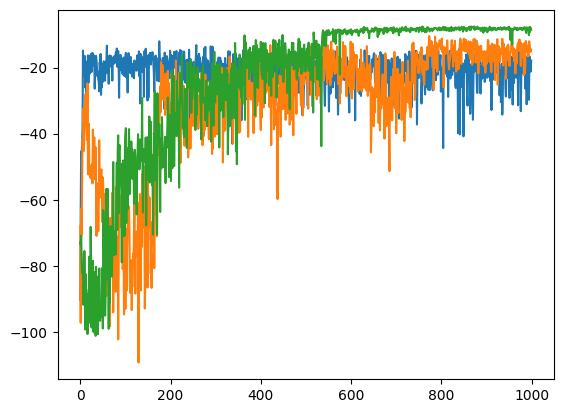

In [706]:
plt.plot(Gs_dqn.mean(axis=0))
plt.plot(Gs_fhdqn.mean(axis=0))
plt.plot(Gs_fhtlr.mean(axis=0))
#plt.ylim(-1, 0.1)
plt.show()

# 6) Test

### 6.1) DQN

In [673]:
def collect_trajectory(env, agent, H):
    states, actions = [], []
    s, _ = env.reset()
    states.append(s)
    for h in range(H):
        a = agent.select_greedy_action(s, h)
        s, _, d, _, _ = env.step(a)
        states.append(s), actions.append(a)

        if d:
            break
    states = np.array(states)
    actions = np.array(actions)
    return states, actions

In [674]:
states, actions = collect_trajectory(ENV, dqn_learner, H)

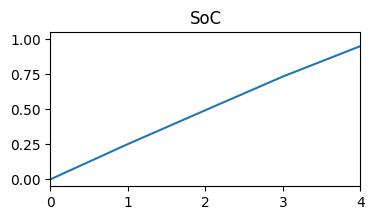

In [675]:
plt.figure(figsize=(4, 2))
plt.title("SoC")
plt.plot(states[:, 0])
plt.xlim(0, 4)
plt.show()

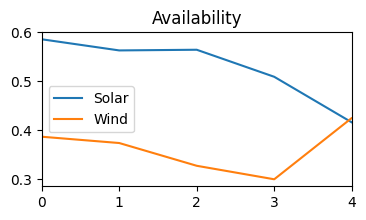

In [676]:
plt.figure(figsize=(4, 2))
plt.title("Availability")
plt.plot(states[:, 1], label='Solar')
plt.plot(states[:, 2], label='Wind')
plt.xlim(0, 4)
plt.legend()
plt.show()

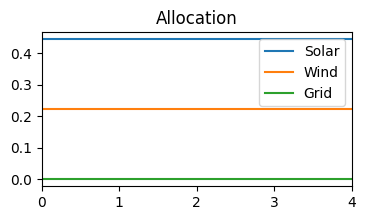

In [677]:
plt.figure(figsize=(4, 2))
plt.title("Allocation")
plt.plot(actions[:, 0], label='Solar')
plt.plot(actions[:, 1], label='Wind')
plt.plot(actions[:, 2], label='Grid')
plt.legend()
plt.xlim(0, 4)
plt.show()

### 6.2) FH-DQN

In [678]:
def collect_trajectory(env, agent, H):
    states, actions = [], []
    s, _ = env.reset()
    states.append(s)
    for h in range(H):
        a = agent.select_greedy_action(s, h)
        s, _, d, _, _ = env.step(a)
        states.append(s), actions.append(a)

        if d:
            break
    states = np.array(states)
    actions = np.array(actions)
    return states, actions

In [687]:
states, actions = collect_trajectory(ENV, dfhqn_learner, H)

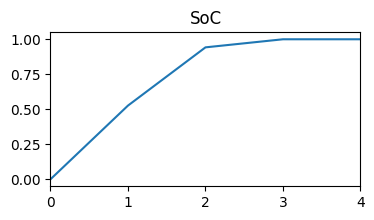

In [688]:
plt.figure(figsize=(4, 2))
plt.title("SoC")
plt.plot(states[:, 0])
plt.xlim(0, 4)
plt.show()

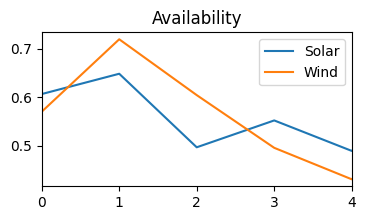

In [689]:
plt.figure(figsize=(4, 2))
plt.title("Availability")
plt.plot(states[:, 1], label='Solar')
plt.plot(states[:, 2], label='Wind')
plt.xlim(0, 4)
plt.legend()
plt.show()

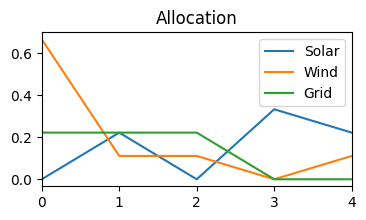

In [690]:
plt.figure(figsize=(4, 2))
plt.title("Allocation")
plt.plot(actions[:, 0], label='Solar')
plt.plot(actions[:, 1], label='Wind')
plt.plot(actions[:, 2], label='Grid')
plt.legend()
plt.xlim(0, 4)
plt.show()

### 6.3) FH-TLR

In [691]:
def collect_trajectory(env, agent, H):
    states, actions = [], []
    s, _ = env.reset()
    states.append(s)
    for h in range(H):
        a = agent.select_greedy_action(s, h)
        s, _, d, _, _ = env.step(a)
        states.append(s), actions.append(a)

        if d:
            break
    states = np.array(states)
    actions = np.array(actions)
    return states, actions

In [696]:
states, actions = collect_trajectory(ENV, fhtlr_learner, H)

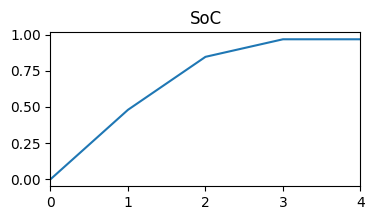

In [697]:
plt.figure(figsize=(4, 2))
plt.title("SoC")
plt.plot(states[:, 0])
plt.xlim(0, 4)
plt.show()

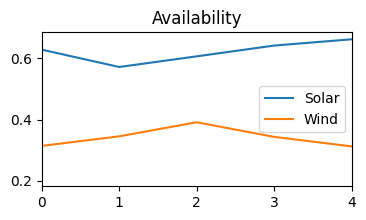

In [698]:
plt.figure(figsize=(4, 2))
plt.title("Availability")
plt.plot(states[:, 1], label='Solar')
plt.plot(states[:, 2], label='Wind')
plt.xlim(0, 4)
plt.legend()
plt.show()

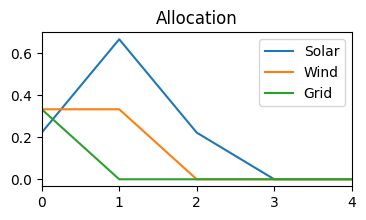

In [699]:
plt.figure(figsize=(4, 2))
plt.title("Allocation")
plt.plot(actions[:, 0], label='Solar')
plt.plot(actions[:, 1], label='Wind')
plt.plot(actions[:, 2], label='Grid')
plt.legend()
plt.xlim(0, 4)
plt.show()